# A multilayer fitting model

One of the main tools in `EasyReflectometry` is the [item library](./item_library.html). 
This allows the user to define their model, using specific parameters for their system of interest (if it is included in the item library). 
These items will impose necessary constraints and computational efficiencies based on the item that is used. 

In this tutorial, we will look at one of these items, that of a `RepeatingMultiLayer` ([documented here](https://easyscience.github.io/EasyReflectometryLib/item_library.html#repeatingmultiLayer)). 
This tutorial is based on an example from the [BornAgain](https://www.bornagainproject.org) documentation looking at [specular reflectivity analysis](https://www.bornagainproject.org/m/py/fitting/extended/fit-specular-data/). 
Before performing analysis, we should import the packages that we need.

First configure matplotlib to place figures in notebook and import needed modules

In [1]:
%matplotlib inline

import numpy as np
import scipp as sc
import EasyReflectometry
import refl1d
from EasyReflectometry.data import load
from EasyReflectometry.sample import Layer, Structure
from EasyReflectometry.sample.material import Material
from EasyReflectometry.sample.item import RepeatingMultiLayer
from EasyReflectometry.experiment.model import Model
from EasyReflectometry.interface import InterfaceFactory as Interface
from EasyReflectometry.fitting import Fitter
from EasyReflectometry.plot import plot

As mentioned in the [previous tutorial](./simple_fitting.html), we share the version of the software packages we will use. 

In [2]:
print(f'numpy: {np.__version__}')
print(f'scipp: {sc.__version__}')
print(f'EasyReflectometry: {EasyReflectometry.__version__}')
print(f'Refl1D: {refl1d.__version__}')

numpy: 1.26.3
scipp: 23.12.0
EasyReflectometry: 0.0.3
Refl1D: 0.8.16


## Reading in experimental data

The data that we will investigate in this tutorial was generated with [GenX](https://aglavic.github.io/genx/) and is stored in an `.ort` [format file](https://github.com/reflectivity/file_format/blob/master/specification.md). 

In [3]:
data = load('_static/repeating_layers.ort')
data

/opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/orsopy/fileio/base.py:277: RuntimeWarning: Has to be one of ('neutron', 'x-ray') got x-rays
  warnings.warn(


DataGroup(sizes={}, keys=[
    data: {'R_0': <scipp.Variable> (Qz_0: 400)    float64  [dimensionless]  [1, 1, ..., 8.97346e-08, 3.67177e-09]  [1.0285e-12, 1.5434e-10, ..., 8.10915e-15, 1.37136e-17],
    coords: {'Qz_0': <scipp.Variable> (Qz_0: 400)    float64           [1/Å]  [0.000712093, 0.00249232, ..., 0.708352, 0.710125]  [0, 0, ..., 0, 0],
    attrs: {'R_0': {'orso_header': <scipp.Variable> ()   PyObject        <no unit>  {'data_source': {'owner': {'name': 'Andrew McCluskey', 'affiliation': 'European Spallation Source', 'contact': 'andrew.mccluskey@ess.eu'}, 'experiment': {'title': 'Ni-Ti Multilayer', 'instrument': 'Simulation', 'start_date': datetime.datetime(2022, 2, 1, 0, 0), 'probe': 'x-rays', 'facility': 'Simulated'}, 'sample': {'name': 'Ni-Ti Multilayer on Si', 'category': 'gas / lsolidiquid', 'composition': 'Air / (Ni / Ti) x 10 / Si'}, 'measurement': {'instrument_settings': {'incident_angle': {'magnitude': 3.0, 'unit': 'deg'}, 'wavelength': {'magnitude': 12.0, 'unit': 'angstrom'}}, 'data_files': ['Unknown.nxs'], 'scheme': 'angle-dispersive'}}, 'reduction': {'software': {'name': 'ess'}, 'timestamp': datetime.datetime(2022, 2, 1, 11, 56, 13, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'corrections': ['simulated']}, 'columns': [{'name': 'Qz', 'unit': '1/angstrom', 'dimension': 'WW transfer'}, {'name': 'R', 'dimension': 'reflectivity'}, {'name': 'sR', 'dimension': 'error-reflectivity'}, {'name': 'sQz', 'unit': '1/angstrom', 'dimension': 'resolution-WW transfer'}]}},
])

This data is very featureful, with many fringes present (arising from the multilayer structure)

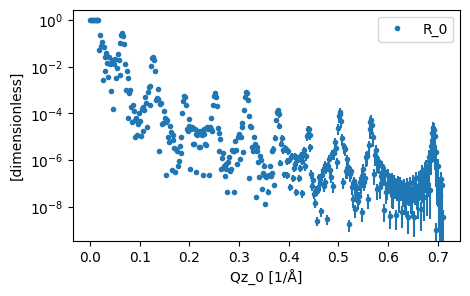

In [4]:
plot(data)

## Building our model

The system that was used to produce the data shown above is based on a silicon subphase, with a repeating multilayer of nickel and titanium grown upon it. 
Typcially, under experimental conditions, the producer of the sample will know how many repeats there will be of the multilayer system (as these are grown using some vapour disposition or sputtering method that the producer controls). 
We show the model that will be used graphically below. 

<center>
    <img src='_static/repeating.png' alt='A slab model description of the repeating multilayer system.' width='300px'></img>
</center>
<center>
    A slab model description of the repeating multilayer, showing the four layers of vacuum, titanium, nickel and silicon, with the titanium/nickel layers being repeated 10 times.
</center>

To construct such a layer structure, first we create each of the materials and associated layers

In [5]:
vacuum = Material.from_pars(0, 0, 'Vacuum')
ti = Material.from_pars(-1.9493, 0, 'Ti')
ni = Material.from_pars(9.4245, 0, 'Ni')
si = Material.from_pars(2.0704, 0, 'Si')

In [6]:
superphase = Layer.from_pars(vacuum, 0, 0, 'Vacuum Superphase')
ti_layer = Layer.from_pars(ti, 40, 0, 'Ti Layer')
ni_layer = Layer.from_pars(ni, 70, 0, 'Ni Layer')
subphase = Layer.from_pars(si, 0, 0, 'Si Subphase')

Then, to produce the repeating multilayer, we use the `RepeatingMultilayer` [item type](https://easyscience.github.io/EasyReflectometryLib/item.html#EasyReflectometry.sample.item.RepeatingMultiLayer). 
This can be constructed in a range of different ways, however here we pass a list of `Layer` type objects and a number of repetitions. 

In [7]:
rep_multilayer = RepeatingMultiLayer.from_pars([ti_layer, ni_layer], repetitions=10, name='NiTi Multilayer')
rep_multilayer

NiTi Multilayer:
  Ti Layer/Ni Layer:
  - Ti Layer:
      material:
        Ti:
          sld: -1.949e-6 1 / angstrom ** 2
          isld: 0.000e-6 1 / angstrom ** 2
      thickness: 40.000 angstrom
      roughness: 0.000 angstrom
  - Ni Layer:
      material:
        Ni:
          sld: 9.425e-6 1 / angstrom ** 2
          isld: 0.000e-6 1 / angstrom ** 2
      thickness: 70.000 angstrom
      roughness: 0.000 angstrom
  repetitions: 10.0

From these objects, we can construct our structure and combine this with a scaling, background and resolution (since this data is simulated there is no background or resolution smearing). 

In [8]:
structure = Structure.from_pars(superphase, rep_multilayer, subphase, name='Multilayer Structure')
model = Model.from_pars(structure, 1, 0, 0, 'Multilayer Model')

In the analysis, we will only vary a single parameter, the thickness of titanium layer. 

In [9]:
ti_layer.thickness.bounds = (10, 60)

## Choosing our calculation engine

In the [previous tutorial](./simple_fitting.html), we used the default [refnx](https://refnx.readthedocs.io/) engine for our analysis. 
Here, we will change our engine to be [*Refl1D*](https://refl1d.readthedocs.io/en/latest/).
This is achieved with the `interface.switch('refl1d')` method below. 

In [10]:
interface = Interface()
interface.switch('refl1d')
model.interface = interface
print(interface.current_interface.name)

refl1d


## Performing an optimisation

The [easyScience](easyScience.github.io/easyCore) framework allows us to access a broad range of optimisation methods.
Below, we have selected the [differential evolution method from lmfit](https://lmfit.github.io/lmfit-py/examples/example_diffev.html).

In [11]:
fitter = Fitter(model)
analysed = fitter.fit(data, method='differential_evolution')
analysed

DataGroup(sizes={'Qz_0': 400, 'z_0': 10200}, keys=[
    data: {'R_0': <scipp.Variable> (Qz_0: 400)    float64  [dimensionless]  [1, 1, ..., 8.97346e-08, 3.67177e-09]  [1.0285e-12, 1.5434e-10, ..., 8.10915e-15, 1.37136e-17],
    coords: {'Qz_0': <scipp.Variable> (Qz_0: 400)    float64           [1/Å]  [0.000712093, 0.00249232, ..., 0.708352, 0.710125]  [0, 0, ..., 0, 0], 'z_0': <scipp.Variable> (z_0: 10200)    float64             [Å]  [-10, -9.9, ..., 1009.8, 1009.9],
    attrs: {'R_0': {'orso_header': <scipp.Variable> ()   PyObject        <no unit>  {'data_source': {'owner': {'name': 'Andrew McCluskey', 'affiliation': 'European Spallation Source', 'contact': 'andrew.mccluskey@ess.eu'}, 'experiment': {'title': 'Ni-Ti Multilayer', 'instrument': 'Simulation', 'start_date': datetime.datetime(2022, 2, 1, 0, 0), 'probe': 'x-rays', 'facility': 'Simulated'}, 'sample': {'name': 'Ni-Ti Multilayer on Si', 'category': 'gas / lsolidiquid', 'composition': 'Air / (Ni / Ti) x 10 / Si'}, 'measurement': {'instrument_settings': {'incident_angle': {'magnitude': 3.0, 'unit': 'deg'}, 'wavelength': {'magnitude': 12.0, 'unit': 'angstrom'}}, 'data_files': ['Unknown.nxs'], 'scheme': 'angle-dispersive'}}, 'reduction': {'software': {'name': 'ess'}, 'timestamp': datetime.datetime(2022, 2, 1, 11, 56, 13, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'corrections': ['simulated']}, 'columns': [{'name': 'Qz', 'unit': '1/angstrom', 'dimension': 'WW transfer'}, {'name': 'R', 'dimension': 'reflectivity'}, {'name': 'sR', 'dimension': 'error-reflectivity'}, {'name': 'sQz', 'unit': '1/angstrom', 'dimension': 'resolution-WW transfer'}]}}, 'R_0_model': {'model': <scipp.Variable> ()   PyObject        <no unit>  {'@module': 'EasyReflectometry.experiment.model', '@class': 'Model', '@version': '0.0.3', 'scale': {'@module': 'easyCore.Objects.Variable', '@class': 'Parameter', '@version': '0.2.2', 'fixed': True, 'enabled': True, 'min': 0, 'display_name': 'scale', 'description': 'Scaling of the reflectomety profile', 'max': inf, 'units': 'dimensionless', 'name': 'scale', 'url': 'https://github.com/reflectivity/edu_outreach/blob/master/refl_maths/paper.tex', 'value': 1.0, 'error': 0.0, '@id': '168453078639749415767151162988511535275'}, 'structure': {'@module': 'EasyReflectometry.sample.structure', '@class': 'Structure', '@version': '0.0.3', 'data': [{'@module': 'EasyReflectometry.sample.items.multilayer', '@class': 'MultiLayer', '@version': '0.0.3', 'layers': {'@module': 'EasyReflectometry.sample.layers', '@class': 'Layers', '@version': '0.0.3', 'data': [{'@module': 'EasyReflectometry.sample.layer', '@class': 'Layer', '@version': '0.0.3', 'roughness': {'@module': 'easyCore.Objects.Variable', '@class': 'Parameter', '@version': '0.2.2', 'fixed': True, 'enabled': True, 'min': 0.0, 'display_name': 'roughness', 'description': 'The interfacial roughness, Nevot-Croce, for the layer in angstroms.', 'max': inf, 'units': 'angstrom', 'name': 'roughness', 'url': 'https://doi.org/10.1051/rphysap:01980001503076100', 'value': 0.0, 'error': 0.0, '@id': '283582940335641083284457460870224932017'}, 'material': {'@module': 'EasyReflectometry.sample.material', '@class': 'Material', '@version': '0.0.3', 'interface': <EasyReflectometry.interface.InterfaceFactory object at 0x7f3747039700>, 'isld': {'@module': 'easyCore.Objects.Variable', '@class': 'Parameter', '@version': '0.2.2', 'fixed': True, 'enabled': True, 'min': -inf, 'display_name': 'isld', 'description': 'The imaginary scattering length density for a material in e-6 per squared angstrom.', 'max': inf, 'units': '1 / angstrom ** 2', 'name': 'isld', 'url': 'https://www.ncnr.nist.gov/resources/activation/', 'value': 0.0, 'error': 0.0, '@id': '36663446549132126170725349038571904585'}, 'name': 'Vacuum', 'sld': {'@module': 'easyCore.Objects.Variable', '@class': 'Parameter', '@version': '0.2.2', 'fixed': True, 'enabled': True, 'min': -inf, 'display_name': 'sld', 'description': 'The real scattering length density for a material in e-6

We can visualise the analysed model and SLD profile with the `plot` function. 

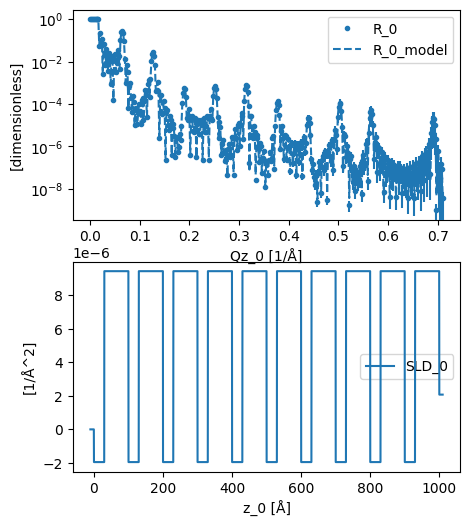

In [12]:
plot(analysed)

The value of the titanium layer thickness that gives this best fit can be found from the relavant object.
Note that the uncertainty of 0 is due to the use of the lmfit differential evolution algorithm, which does not include uncertainty analysis. 

In [13]:
ti_layer.thickness

<Parameter 'thickness': 29.987946086166435+/-0 Å, bounds=[10:60]>

This result of a thickness of 30 Å is the same as that which is used to produce the data. 